In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 3
img = np.random.randint(180, size=(SIZE, SIZE, 3)) + 50

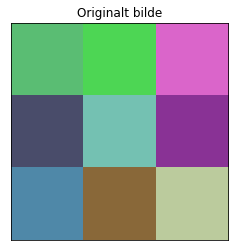

In [3]:
plt.imshow(img, vmin=0, vmax=255)
plt.title("Originalt bilde")
plt.xticks([])
plt.yticks([])
print()

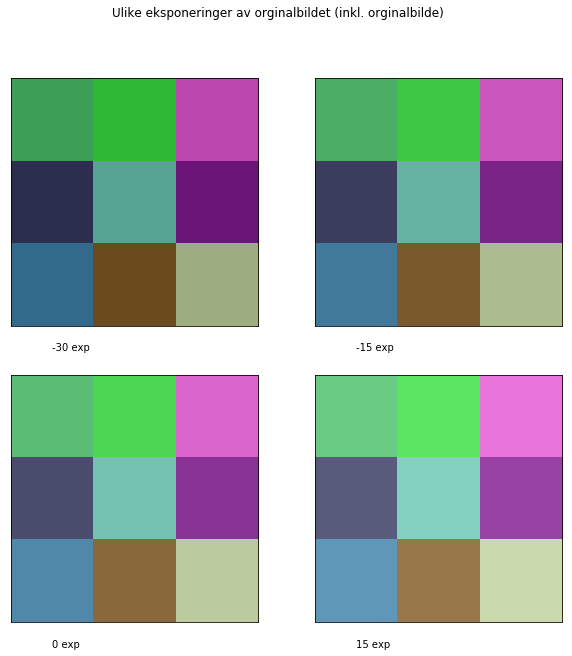

In [4]:
N = 4
EXP_OFFSET = 15

exps_offsets = np.arange(-N // 2, N // 2) * EXP_OFFSET
exs = np.array([(img + offset).clip(0, 255) for offset in exps_offsets])

fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.suptitle("Ulike eksponeringer av orginalbildet (inkl. orginalbilde)")

for i, imge in enumerate(exs):
    ax = fig.add_subplot(N // 2, (N + 1) // 2, i + 1, xticks=[], yticks=[])
    ax.imshow(imge, vmin=0, vmax=255)
    ax.text(0, SIZE - .2, '%d exp' % exps_offsets[i])

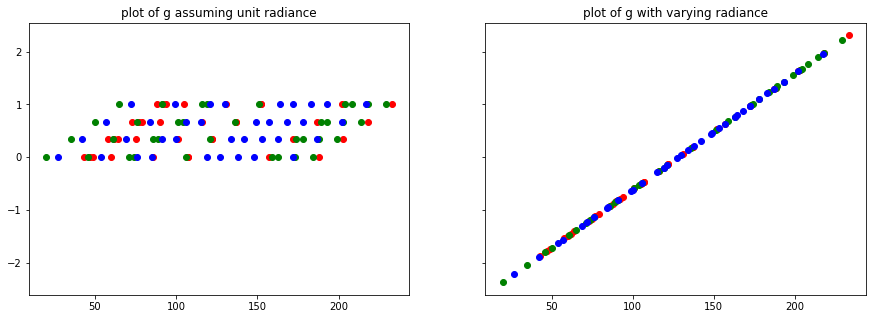

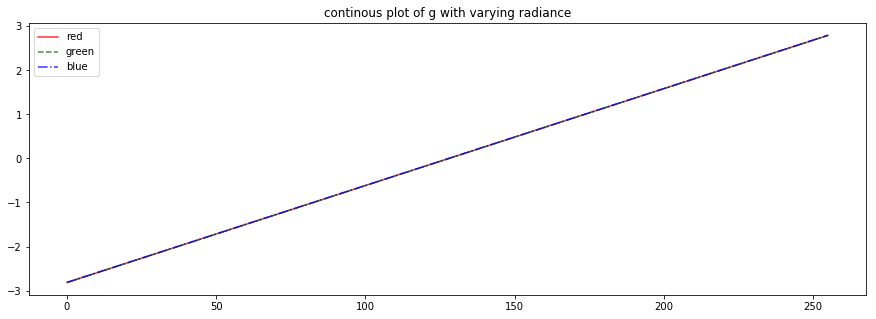

In [13]:
from hdrie.rekonstruksjon import debevec_maliks_color

Z_rgb = exs.reshape(exs.shape[0], exs.shape[1]**2, -1).transpose()

dT = np.linspace(.01, 1, N)

def w(z): return 128 - np.abs(128 - z)

kurves = debevec_maliks_color(Z_rgb, dT, .1, w, 256)

fig1, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
fig2, ax = plt.subplots(1, 1, figsize=(15, 5))

for (color, shape), (Z, (p, lE)) in zip([('r', '-'), ('g', '--'), ('b', '-.')], zip(Z_rgb, kurves)):
    axs[0].set_title("plot of g assuming unit radiance")
    for pos, pix in enumerate(Z):
        axs[0].plot(pix, p[pix] - lE[pos], color + 'o')

    axs[1].set_title("plot of g with varying radiance")
    for pos, pix in enumerate(Z):
        axs[1].plot(pix, p[pix], color + 'o')

    ax.set_title('continous plot of g with varying radiance')
    ax.plot(p, color + shape, alpha=0.8)

ax.legend(['red', 'green', 'blue'])